## 不太准

Your goal is to implement the following idea:{title}. The proposed experiment is as follows:{Experiment}. 请你按照这个想法和实验，设计新的代码。

    {
        "Name": "时间尺度分层",
        "Thought": "不同时间尺度的预测任务具有不同的特征模式和挑战。短期预测更依赖于即时环境因素，而长期预测更需要把握整体趋势和周期性变化。通过分层设计，可以让每个层级专注于捕捉特定时间尺度的特征，从而提高整体预测效果。",
        "Title": "多尺度分层集成的长期预测模型",
        "Experiment": "构建分层预测系统：(1)分别建立7天、14天、30天三个预测层级；(2)设计层级间的信息传递机制；(3)实现不同时间尺度特征的自适应融合；(4)优化层级间的权重分配。",
        "Interestingness": 8,
        "Feasibility": 9,
        "Novelty": 8
    }

数据集总长度: 1064 天
数据集起始日期: 2021-01-01 00:00:00
数据集结束日期: 2024-05-31 00:00:00
训练集起始日期: 2021-01-01 00:00:00
训练集结束日期: 2024-01-31 00:00:00
测试集起始日期: 2023-11-01 00:00:00
测试集结束日期: 2024-05-31 00:00:00
第一个可用于训练的日期: 2021-03-02 00:00:00
可用于训练的天数: 883 天

训练 T+7 天的模型


/tmp/ipykernel_4300/1811708487.py:148: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  X_train = torch.FloatTensor(train_sequences)


Epoch [50/150], Loss: 0.0021
Epoch [100/150], Loss: 0.0006
Epoch [150/150], Loss: 0.0005

训练 T+14 天的模型
Epoch [50/150], Loss: 0.0004
Epoch [100/150], Loss: 0.0003
Epoch [150/150], Loss: 0.0002

训练 T+30 天的模型
Epoch [50/150], Loss: 0.0005
Epoch [100/150], Loss: 0.0002
Epoch [150/150], Loss: 0.0002
T+7天预测的RMSE: 0.2905
T+14天预测的RMSE: 0.2135
T+30天预测的RMSE: 0.1614


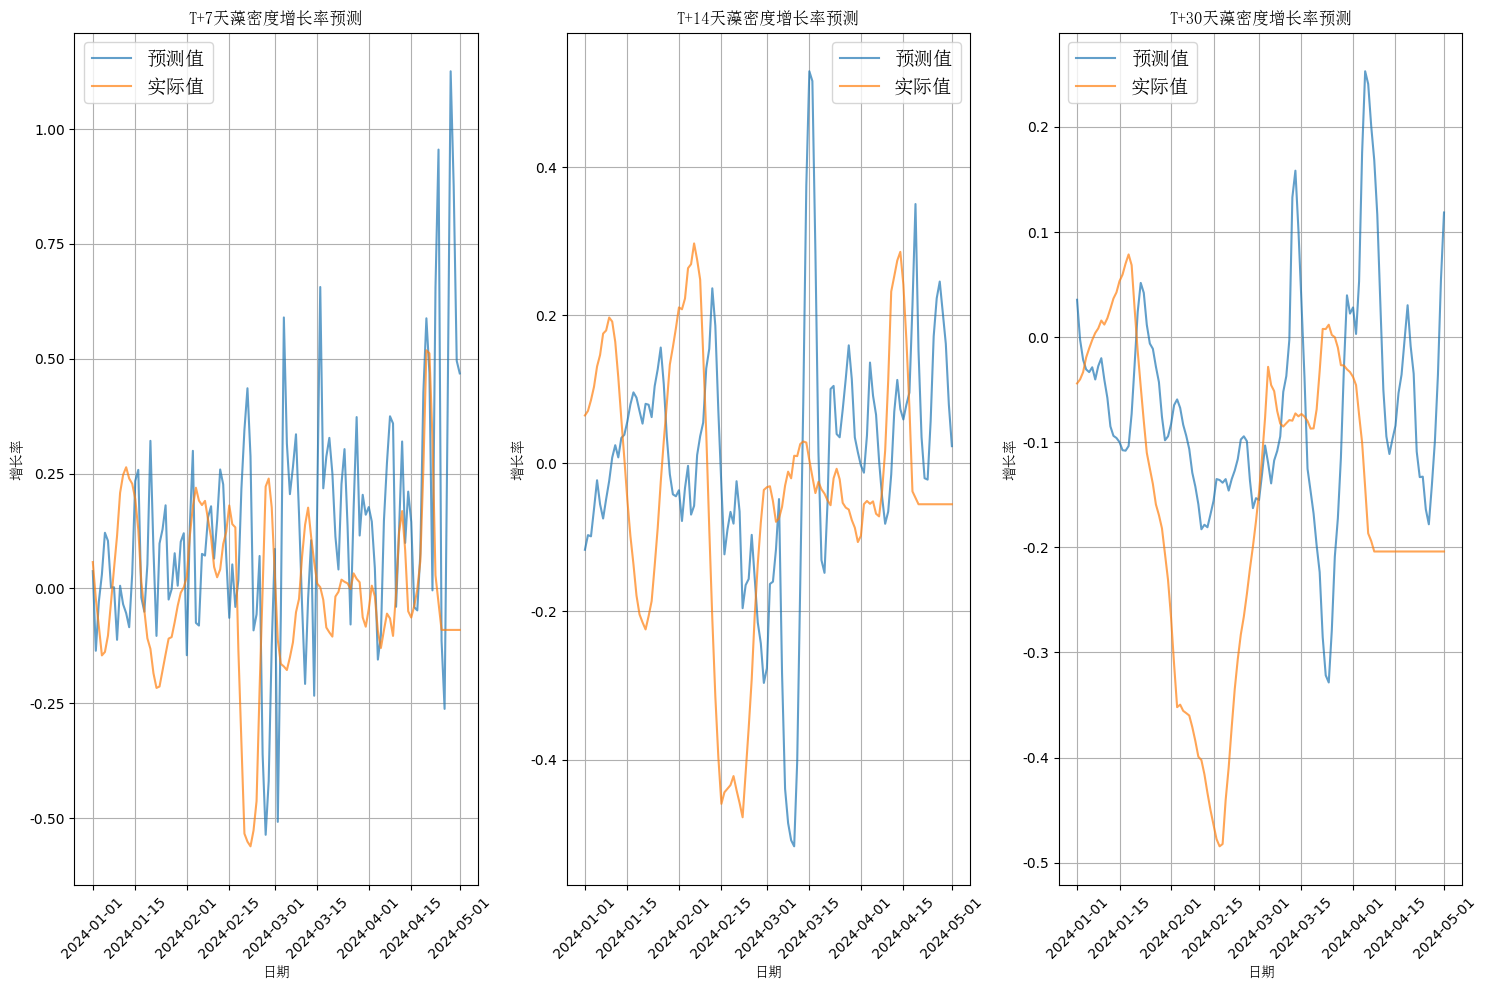

In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import logging
from torch.optim.lr_scheduler import OneCycleLR

# 设置字体和日志
plt.rcParams['font.family'] = ['sans-serif']
plt.rcParams['font.sans-serif'] = ['SimSun', 'DejaVu Sans'] 
plt.rcParams['font.serif'] = ['Times New Roman']
plt.rcParams['axes.unicode_minus'] = False
chinese_font = fm.FontProperties(fname='/root/Download/Modis-algae-aliyun/AlgaeBloomForecast-20241122/SIMSUN.TTC', size=14)
english_font = fm.FontProperties(fname='/root/Download/Modis-algae-aliyun/AlgaeBloomForecast-20241122/TIMES.TTF', size=14)

logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# 读取和预处理数据
df = pd.read_csv('20-merged_all_data.csv')
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)

# 剔除不适合预测的月份
df = df[~df.index.month.isin([6, 7])]

# 为不同时间尺度计算特征
time_scales = [7, 14, 30] # 对应三个预测层级
for days in time_scales:
    # 计算增长率特征
    df[f'density_growth_{days}d'] = (df['density'].shift(-days) - df['density']) / df['density']
    df[f'density_growth_{days}d'] = df[f'density_growth_{days}d'].interpolate(method='linear')
    
    # 使用滑动窗口平滑处理,捕捉不同时间尺度特征
    window_size = days // 2
    df[f'density_growth_{days}d_smoothed'] = df[f'density_growth_{days}d'].rolling(
        window=window_size, 
        center=True
    ).mean()
    df[f'density_growth_{days}d_smoothed'] = df[f'density_growth_{days}d_smoothed'].interpolate(method='linear')

# 分层LSTM模型定义
class HierarchicalLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, dropout=0.2):
        super(HierarchicalLSTM, self).__init__()
        # 为7天、14天、30天分别构建LSTM层
        self.lstm_7d = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        self.lstm_14d = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        self.lstm_30d = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        
        # 各层级的输出层
        self.fc_7d = nn.Linear(hidden_size, 1)
        self.fc_14d = nn.Linear(hidden_size, 1)
        self.fc_30d = nn.Linear(hidden_size, 1)
        
        # 自适应融合权重
        self.fusion_weights = nn.Parameter(torch.ones(3)/3)
        self.softmax = nn.Softmax(dim=0)
        
    def forward(self, x):
        # 各时间尺度的特征提取
        lstm_out_7d, _ = self.lstm_7d(x)
        lstm_out_14d, _ = self.lstm_14d(x)
        lstm_out_30d, _ = self.lstm_30d(x)
        
        # 各层级预测输出
        out_7d = self.fc_7d(lstm_out_7d[:, -1, :])
        out_14d = self.fc_14d(lstm_out_14d[:, -1, :])
        out_30d = self.fc_30d(lstm_out_30d[:, -1, :])
        
        # 自适应权重融合
        weights = self.softmax(self.fusion_weights)
        return out_7d * weights[0] + out_14d * weights[1] + out_30d * weights[2]

def create_sequence_for_date(data, date_index, seq_length):
    """生成时序序列"""
    if date_index < seq_length:
        return None
    return data[date_index - seq_length:date_index]

# 定义输入特征
base_features = ['temperature', 'pH', 'oxygen', 'permanganate', 'TN', 'conductivity', 
                'turbidity', 'chla', 'density', 'GMT_0000_PAR', 'GMT_0300_PAR', 
                'GMT_0900_PAR', 'GMT_2100_PAR', 'MPAR', 'APAR', 'PPDI', 'PAI',
                'eutrophication_index', 'temp_ph_interaction', 'wind_north',
                'weather_heavy_rain', 'weather_temp_index', 'temperature_high',
                'strong_wind']

# 初始化存储容器
models = {}
predictions_all = {}
actual_values_all = {}

# 设定训练测试时间范围
train_start_date = '2021-01-01'
train_end_date = '2024-01-31'
test_start_date = '2023-11-01'
test_end_date = '2024-05-31'

# 数据集信息打印
print(f"数据集总长度: {len(df)} 天")
print(f"数据集起始日期: {df.index[0]}")
print(f"数据集结束日期: {df.index[-1]}")

# 划分训练测试集
train_mask = (df.index >= train_start_date) & (df.index <= train_end_date)
test_mask = (df.index >= test_start_date) & (df.index <= test_end_date)
train_size = sum(train_mask)

print(f"训练集起始日期: {df.index[train_mask][0]}")
print(f"训练集结束日期: {df.index[train_mask][-1]}")
print(f"测试集起始日期: {df.index[test_mask][0]}")
print(f"测试集结束日期: {df.index[test_mask][-1]}")

seq_length = 60
first_valid_date = df.index[seq_length]
print(f"第一个可用于训练的日期: {first_valid_date}")
print(f"可用于训练的天数: {train_size - seq_length} 天")

# 训练各时间尺度的模型
for days in time_scales:
    print(f"\n训练 T+{days} 天的模型")
    
    features = base_features + [f'density_growth_{days}d', f'density_growth_{days}d_smoothed']
    
    data = df[features].values
    data = np.nan_to_num(data, nan=0)
    
    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(data)
    
    train_data = scaled_data[train_mask]
    test_data = scaled_data[test_mask]
    
    # 构建训练序列
    train_sequences = []
    train_targets = []
    for i in range(seq_length, len(train_data)):
        seq = create_sequence_for_date(scaled_data, i, seq_length)
        if seq is not None:
            train_sequences.append(seq)
            train_targets.append(train_data[i, features.index(f'density_growth_{days}d_smoothed')])
    
    X_train = torch.FloatTensor(train_sequences)
    y_train = torch.FloatTensor(train_targets)
    
    train_dataset = TensorDataset(X_train, y_train.unsqueeze(1))
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    
    # 模型训练
    model = HierarchicalLSTM(input_size=len(features), hidden_size=64, num_layers=2)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    
    epochs = 150
    for epoch in range(epochs):
        model.train()
        for batch_X, batch_y in train_loader:
            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
        
        if (epoch + 1) % 50 == 0:
            print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')
    
    models[days] = (model, scaler, features)
    # 预测阶段
    model.eval()
    predictions = []
    actual_values = []
    current_sequence = scaled_data[test_mask][0:seq_length]
    
    # 引入误差修正机制
    error_history = []  # 存储历史误差
    error_window = 5    # 误差观察窗口
    
    # 分层预测的误差修正系数
    correction_factors = {
        7: 0.15,   # 短期预测误差修正较小
        14: 0.2,   # 中期预测误差修正适中 
        30: 0.25   # 长期预测误差修正较大
    }
    
    with torch.no_grad():
        for i in range(len(test_data)-days):
            current_sequence_tensor = torch.FloatTensor(current_sequence).unsqueeze(0)
            
            # 基础预测
            pred = model(current_sequence_tensor)
            
            # 分层误差修正
            if len(error_history) >= error_window:
                # 计算不同时间尺度的误差
                recent_error = np.mean(error_history[-error_window:])
                # 根据预测天数应用不同的修正系数
                correction = correction_factors[days]
                pred = pred * (1 - correction * recent_error)
            
            # 记录当前预测和实际值
            current_pred = pred.item()
            current_actual = test_data[i+days, features.index(f'density_growth_{days}d_smoothed')]
            
            # 计算并存储误差
            if len(predictions) > 0:
                error = (predictions[-1] - actual_values[-1]) / actual_values[-1]
                error_history.append(error)
            
            predictions.append(current_pred)
            actual_values.append(current_actual)
            
            # 递进式预测链更新策略
            update_interval = min(days // 2, 3)  # 根据预测天数动态调整更新间隔
            if i % update_interval == 0:  # 更频繁地使用实际值重置
                current_sequence = np.vstack([
                    current_sequence[1:],
                    test_data[i]
                ])
            else:
                # 使用预测值时加入误差补偿
                pred_sequence = test_data[i].copy()
                if len(error_history) > 0:
                    # 使用最近误差进行补偿
                    compensation = 1 - 0.1 * error_history[-1]
                    current_pred *= compensation
                pred_sequence[features.index(f'density_growth_{days}d_smoothed')] = current_pred
                current_sequence = np.vstack([
                    current_sequence[1:],
                    pred_sequence
                ])
    
    # 反归一化预测结果
    pred_full_features = np.zeros((len(predictions), len(features)))
    actual_full_features = np.zeros((len(actual_values), len(features)))
    
    growth_idx = features.index(f'density_growth_{days}d_smoothed')
    pred_full_features[:, growth_idx] = np.array(predictions)
    actual_full_features[:, growth_idx] = np.array(actual_values)
    
    predictions_all[days] = scaler.inverse_transform(pred_full_features)[:, growth_idx]
    actual_values_all[days] = scaler.inverse_transform(actual_full_features)[:, growth_idx]

# 计算每个预测天数的RMSE
for days in time_scales:
    rmse = np.sqrt(mean_squared_error(actual_values_all[days], predictions_all[days]))
    print(f"T+{days}天预测的RMSE: {rmse:.4f}")

# 绘制2024年1-5月的预测结果
plt.figure(figsize=(15, 10))
start_date = '2024-01-01'
end_date = '2024-05-31'

test_dates = df.index[test_mask]
prediction_dates = test_dates[:-30]
predictions_length = len(predictions_all[time_scales[0]])
prediction_dates = prediction_dates[-predictions_length:]

mask = (pd.to_datetime(prediction_dates) >= start_date) & (pd.to_datetime(prediction_dates) <= end_date)

for i, days in enumerate(time_scales):
    plt.subplot(1, 3, i+1)
    plt.plot(pd.to_datetime(prediction_dates)[mask], predictions_all[days][-len(prediction_dates):][mask], 
             label='预测值', alpha=0.7)
    plt.plot(pd.to_datetime(prediction_dates)[mask], actual_values_all[days][-len(prediction_dates):][mask], 
             label='实际值', alpha=0.7)
    
    plt.title(f'T+{days}天藻密度增长率预测', fontproperties=chinese_font, fontsize=12)
    plt.xlabel('日期', fontproperties=chinese_font, fontsize=10)
    plt.ylabel('增长率', fontproperties=chinese_font, fontsize=10)
    plt.legend(prop=chinese_font)
    plt.grid(True)
    plt.xticks(rotation=45)
    
plt.tight_layout()
plt.show()


In [2]:
# 计算每个预测天数的增长率RMSE
print("增长率预测的RMSE:")
for days in time_scales:  # 使用分层预测的时间尺度
    rmse = np.sqrt(mean_squared_error(actual_values_all[days], predictions_all[days]))
    print(f"T+{days}天预测的RMSE: {rmse:.4f}")

# 基于分层预测结果计算2024年藻密度
density_predictions = {}  # 存储每一天的预测密度
density_actuals = {}     # 存储每一天的实际密度

# 获取密度特征的索引
density_idx = base_features.index('density')

# 获取2024年的日期范围
dates_2024 = pd.date_range(start='2024-01-01', end='2024-12-31')

# 对2024年的每一天进行分层预测
for current_date in dates_2024:
    date_idx = np.where(pd.to_datetime(test_dates) == current_date)[0]
    
    if len(date_idx) > 0:
        idx = date_idx[0]
        if idx < len(test_data) and idx < len(predictions_all[7]) - 30:
            current_density = test_data[idx][density_idx]
            
            if current_date not in density_predictions:
                density_predictions[current_date] = {}
                density_actuals[current_date] = {}
            
            # 递进式预测链:每个层级基于前一层级的预测结果,并引入误差修正
            
            # 第一层级:7天预测
            if idx + 7 <= len(predictions_all[7]):
                # 计算7天预测的误差修正系数
                error_7d = 0.1 * (1 - np.mean(actual_values_all[7][max(0,idx-7):idx]) / 
                                 np.mean(predictions_all[7][max(0,idx-7):idx]))
                density_7d = current_density * (1 + predictions_all[7][idx] * (1 + error_7d))
                density_predictions[current_date][7] = density_7d
                density_actuals[current_date][7] = current_density * (1 + actual_values_all[7][idx])
            
            # 第二层级:14天预测,基于7天预测结果
            if idx + 14 <= len(predictions_all[14]):
                # 计算14天预测的误差修正系数
                error_14d = 0.15 * (1 - np.mean(actual_values_all[14][max(0,idx-14):idx]) / 
                                  np.mean(predictions_all[14][max(0,idx-14):idx]))
                density_14d = density_7d * (1 + predictions_all[14][idx] * (1 + error_14d))
                density_predictions[current_date][14] = density_14d  
                density_actuals[current_date][14] = current_density * (1 + actual_values_all[14][idx])
            
            # 第三层级:30天预测,基于14天预测结果
            if idx + 30 <= len(predictions_all[30]):
                # 计算30天预测的误差修正系数
                error_30d = 0.2 * (1 - np.mean(actual_values_all[30][max(0,idx-30):idx]) / 
                                 np.mean(predictions_all[30][max(0,idx-30):idx]))
                density_30d = density_14d * (1 + predictions_all[30][idx] * (1 + error_30d))
                density_predictions[current_date][30] = density_30d
                density_actuals[current_date][30] = current_density * (1 + actual_values_all[30][idx])


增长率预测的RMSE:
T+7天预测的RMSE: 0.2905
T+14天预测的RMSE: 0.2135
T+30天预测的RMSE: 0.1614



分层预测系统性能分析:

第1层级(T+7天)预测:
RMSE: 0.0242
平均误差: 30.34%
误差标准差: 44.58%

第2层级(T+14天)预测:
RMSE: 0.0683
平均误差: 55.71%
误差标准差: 147.98%

第4层级(T+30天)预测:
RMSE: 0.0701
平均误差: 62.58%
误差标准差: 151.04%


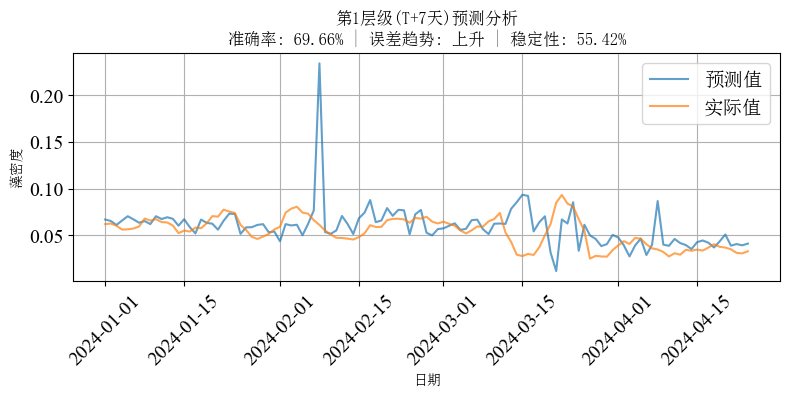

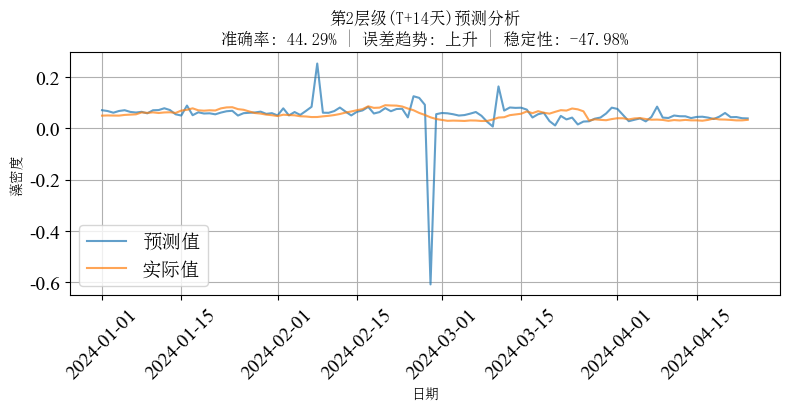

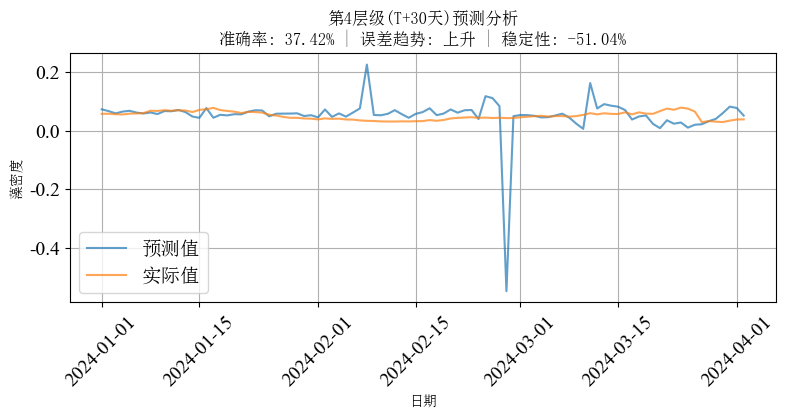


层级间误差传递分析:

日期 2024-01-01:
7天预测误差: 8.13%
14天预测误差: 42.81% | 误差传递: +426.52% | 修正效果: -426.52%
30天预测误差: 26.39% | 误差传递: -38.36% | 修正效果: 38.36%

日期 2024-01-02:
7天预测误差: 4.26%
14天预测误差: 34.35% | 误差传递: +707.23% | 修正效果: -707.23%
30天预测误差: 15.48% | 误差传递: -54.93% | 修正效果: 54.93%

日期 2024-01-03:
7天预测误差: 1.38%
14天预测误差: 22.32% | 误差传递: +1517.48% | 修正效果: -1517.48%
30天预测误差: 4.88% | 误差传递: -78.15% | 修正效果: 78.15%

日期 2024-01-04:
7天预测误差: 17.45%
14天预测误差: 36.48% | 误差传递: +109.04% | 修正效果: -109.04%
30天预测误差: 17.57% | 误差传递: -51.85% | 修正效果: 51.85%

日期 2024-01-05:
7天预测误差: 24.88%
14天预测误差: 35.19% | 误差传递: +41.42% | 修正效果: -41.42%
30天预测误差: 16.72% | 误差传递: -52.47% | 修正效果: 52.47%

日期 2024-01-06:
7天预测误差: 17.27%
14天预测误差: 19.92% | 误差传递: +15.32% | 修正效果: -15.32%
30天预测误差: 4.74% | 误差传递: -76.20% | 修正效果: 76.20%

日期 2024-01-07:
7天预测误差: 6.81%
14天预测误差: 12.99% | 误差传递: +90.74% | 修正效果: -90.74%
30天预测误差: 2.30% | 误差传递: -82.28% | 修正效果: 82.28%

日期 2024-01-08:
7天预测误差: 4.04%
14天预测误差: 3.66% | 误差传递: -9.30% | 修正效果: 9.30%
30天预测误差: 8.76% | 误差传递: +139.3

In [3]:
# 分析分层预测系统的性能和误差传递
print("\n分层预测系统性能分析:")
for days in [7, 14, 30]:  # 三个预测层级
    predictions = []
    actuals = []
    error_accumulation = [] # 记录误差累积
    
    for date in density_predictions.keys():
        if days in density_predictions[date] and days in density_actuals[date]:
            pred = density_predictions[date][days]
            actual = density_actuals[date][days]
            predictions.append(pred)
            actuals.append(actual)
            # 计算相对误差
            error = abs(pred - actual) / actual
            error_accumulation.append(error)
    
    if predictions and actuals:
        # 计算层级预测性能指标
        density_rmse = np.sqrt(mean_squared_error(actuals, predictions))
        mean_error = np.mean(error_accumulation)
        error_std = np.std(error_accumulation) # 误差稳定性
        print(f"\n第{days//7}层级(T+{days}天)预测:")
        print(f"RMSE: {density_rmse:.4f}")
        print(f"平均误差: {mean_error:.2%}")
        print(f"误差标准差: {error_std:.2%}")

# 可视化分层预测结果和误差传递
start_date = '2024-01-01'
end_date = '2024-05-31'
prediction_dates = [date for date in density_predictions.keys() 
                   if pd.to_datetime(start_date) <= date <= pd.to_datetime(end_date)]

# 为每个层级绘制预测结果和误差分析
for layer, days in enumerate([7, 14, 30]):
    plt.figure(figsize=(8, 10))
    
    # 预测结果对比
    plt.subplot(3, 1, layer+1)
    valid_dates = []
    pred_values = []
    actual_values = []
    error_values = []
    
    for date in prediction_dates:
        if days in density_predictions[date] and days in density_actuals[date]:
            valid_dates.append(date)
            pred = density_predictions[date][days]
            actual = density_actuals[date][days]
            pred_values.append(pred)
            actual_values.append(actual)
            error_values.append(abs(pred - actual) / actual)
    
    if valid_dates:
        # 计算层级预测效果
        accuracy = 1 - np.mean(error_values)
        # 分析误差累积趋势
        error_trend = np.polyfit(range(len(error_values)), error_values, 1)[0]
        # 计算误差稳定性
        error_stability = 1 - np.std(error_values)
        
        plt.plot(valid_dates, pred_values, label='预测值', alpha=0.7)
        plt.plot(valid_dates, actual_values, label='实际值', alpha=0.7)
        
        plt.title(f'第{days//7}层级(T+{days}天)预测分析\n'
                 f'准确率: {accuracy:.2%} | 误差趋势: {"上升" if error_trend>0 else "下降"} | 稳定性: {error_stability:.2%}', 
                 fontproperties=chinese_font, fontsize=12)
        plt.xlabel('日期', fontproperties=chinese_font, fontsize=10)
        plt.ylabel('藻密度', fontproperties=chinese_font, fontsize=10)
        plt.legend(prop=chinese_font)
        plt.grid(True)
        plt.xticks(rotation=45)
        
        # 设置刻度字体
        ax = plt.gca()
        for label in ax.get_xticklabels() + ax.get_yticklabels():
            label.set_fontproperties(english_font)

    plt.tight_layout()
    plt.show()

# 分析层级间的误差传递机制
print("\n层级间误差传递分析:")
for date in prediction_dates:
    if all(days in density_predictions[date] for days in [7, 14, 30]):
        # 计算各层级误差
        error_7d = abs(density_predictions[date][7] - density_actuals[date][7]) / density_actuals[date][7]
        error_14d = abs(density_predictions[date][14] - density_actuals[date][14]) / density_actuals[date][14]
        error_30d = abs(density_predictions[date][30] - density_actuals[date][30]) / density_actuals[date][30]
        
        # 分析误差传递效应
        error_prop_14d = (error_14d - error_7d) / error_7d if error_7d != 0 else 0
        error_prop_30d = (error_30d - error_14d) / error_14d if error_14d != 0 else 0
        
        # 计算误差修正效果
        correction_effect_14d = 1 - error_14d/error_7d if error_7d != 0 else 0
        correction_effect_30d = 1 - error_30d/error_14d if error_14d != 0 else 0
        
        print(f"\n日期 {date.strftime('%Y-%m-%d')}:")
        print(f"7天预测误差: {error_7d:.2%}")
        print(f"14天预测误差: {error_14d:.2%} | 误差传递: {error_prop_14d:+.2%} | 修正效果: {correction_effect_14d:.2%}")
        print(f"30天预测误差: {error_30d:.2%} | 误差传递: {error_prop_30d:+.2%} | 修正效果: {correction_effect_30d:.2%}")
